# Ingresos futuros según la Data

El plan es contruir un modelo de clasificación supervisada que, a partir de datos demográficos y socioeconómicos de una persona adulta (edad, nivel educativo, ocupación, estado civil, país de origen, etc.), prediga si dicha persona ganará más o menos de 50,000 USD al año.

***Objetivos***
* Explorar los datos del censo.
* Construir perfiles socioeconómicos.
* Explorar la importancia y peso de variables sociales (educación, género, raza, etc.) en predicciones económicas.
* Aplicar técnicas de sistemas de recomendación.
* Visualizar y comunicar hallazgos de forma profesional.

## 0. Importar librerías

In [18]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pickle

## 1. Cargar del conjunto de datos

In [2]:
adult = fetch_ucirepo(id=2) 
  
X = adult.data.features 
y = adult.data.targets 
  
print(X.describe()) 

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


In [3]:
df = X.copy()
df["income"] = y.iloc[:,0]
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 2. Preprocesamiento de datos
**2.1. Identificando nulos y duplicados**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
df.isna().sum()[df.isna().sum()>0]

workclass         963
occupation        966
native-country    274
dtype: int64

In [6]:
if df.duplicated().sum():
    df = df.drop_duplicates()
print(df.shape)
df.head()

(48813, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


**2.2. Eliminar información irrelevante**

* `fnlwgt`: Este campo representa el peso final de la muestra, que es un valor utilizado para ajustar las estimaciones estadísticas y no aporta información relevante para el análisis de ingresos.
* `education`: Aunque el nivel educativo es relevante, la columna `education-num` ya proporciona una representación numérica del nivel educativo, lo que facilita el análisis y modelado. 


In [7]:
df.drop(["fnlwgt", "education"], axis = 1, inplace = True)
df.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


**2.3. Transformación de categórico a numérico**

In [8]:
df["income"].unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

In [9]:
y = ((df["income"].replace(r"\.$", "", regex=True)).str.lower().eq(">50k")).astype(int)
X = df.drop(columns = ["income"])
X.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [10]:
y

0        0
1        0
2        0
3        0
4        0
        ..
48837    0
48838    0
48839    0
48840    0
48841    1
Name: income, Length: 48813, dtype: int64

**2.4. Pipeline de procesamiento**

In [11]:
num_features = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
cat_features = ["workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

In [12]:
num_pipe = Pipeline(
    [
      ("imputer", SimpleImputer(strategy = "median")),
      ("scaler", StandardScaler())
    ]
)

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("cat", cat_pipe, cat_features)
])

model = Pipeline(
    [
        ("pre", pre), 
        ("clf", LogisticRegression(max_iter = 1000, class_weight = "balanced"))
    ]
)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
40819,70,NaN,15,Divorced,NaN,Not-in-family,White,Male,2538,0,45,United-States
40613,30,Private,8,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,44,United-States
45445,59,Private,13,Separated,Exec-managerial,Not-in-family,White,Male,0,0,45,United-States
31318,22,Private,10,Never-married,Adm-clerical,Unmarried,Black,Female,0,0,30,United-States
3719,21,Local-gov,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,Guatemala


In [14]:
model.fit(X_train, y_train)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 3. Bases de la recomedación
Siendo que el objetivo es ver estrategias para que los usuarios ganen >50k
* ``¿Qué se quiere recomendar?``: Cambios en los perfiles que permitan dicho objetivo
* `¿Cuál será el "usuario" en este caso?`: Cada persona con sus características en el dataset, cada fila que lo compone
* `¿Qué variables definen el perfil de un usuario?`: age, education-num, workclass, occupation, hours-per-week, etc...

## 4. Contruir un sistema de recomendación

In [15]:
def recomendar_mejoras(profile, threshold_top=0.80, threshold_mid=0.60):
    df_profile = pd.DataFrame([profile])
    prob = model.predict_proba(df_profile)[0, 1]
    
    print(f"Probabilidad actual: {prob * 100:.2f}%")
    
    if prob >= threshold_top:
        print("✔ Alta probabilidad: ya tienes un perfil favorable")
    elif prob >= threshold_mid:
        print("- Probabilidad media: podrías mejorar en algunos aspectos")
    else:
        print("✖ Baja probabilidad: necesitas mejoras para superar los 50K")
    
    recomendaciones = []
    resultados = {"Actual": prob}
    
    # Aumentar educación
    if profile["education-num"] < 16:
        diferencia = 16 - profile["education-num"]
        perfil_mejorado = profile.copy()
        perfil_mejorado["education-num"] += diferencia # Simula obtener un título universitario
        
        prob_mejorada = model.predict_proba(pd.DataFrame([perfil_mejorado]))[0, 1]
        recomendaciones.append(("Aumentar educación a nivel universitario", prob_mejorada))
        resultados["Mejorar educación"] = prob_mejorada
    
    # Aumentar horas trabajadas
    if profile["hours-per-week"] < 40:
        diferencia = 40 - profile["hours-per-week"]
        perfil_mejorado = profile.copy()
        perfil_mejorado["hours-per-week"] += diferencia # Simula trabajar 40 horas/semana

        prob_mejorada = model.predict_proba(pd.DataFrame([perfil_mejorado]))[0, 1]
        recomendaciones.append(("Trabajar hasta 40 horas semanales", prob_mejorada))
        resultados["Trabajar 40h"] = prob_mejorada
    
    # Cambiar a ocupación ejecutiva 
    if profile["occupation"] != "Exec-managerial":
        ocupacion = profile["occupation"]
        perfil_mejorado = profile.copy()
        perfil_mejorado["occupation"] = "Exec-managerial"
        prob_mejorada = model.predict_proba(pd.DataFrame([perfil_mejorado]))[0, 1]
        recomendaciones.append((f"Cambiar de {ocupacion} a ocupación ejecutiva", prob_mejorada))
        resultados["Cambiar a ejecutivo"] = prob_mejorada
    
    # Mostrar recomendaciones ordenadas por impacto
    recomendaciones.sort(key=lambda x: x[1], reverse=True)

    print("\nRecomendaciones (impacto en probabilidad):")
    for rec, prob in recomendaciones:
        print(f"- {rec}: probabilidad = {prob * 100:.2f}%")
    
    return resultados


## 5. Prueba con casos simulados

In [16]:
perfiles = [
    {
        "age": 25,
        "education-num": 9,
        "workclass": "Private",
        "marital-status": "Never-married",
        "occupation": "Sales",
        "relationship": "Not-in-family",
        "race": "White",
        "sex": "Male",
        "capital-gain": 0,
        "capital-loss": 0,
        "hours-per-week": 30,
        "native-country": "United-States"
    },
    {
        "age": 40,
        "education-num": 12,
        "workclass": "Self-emp-not-inc",
        "marital-status": "Married-civ-spouse",
        "occupation": "Tech-support",
        "relationship": "Husband",
        "race": "White",
        "sex": "Male",
        "capital-gain": 0,
        "capital-loss": 0,
        "hours-per-week": 38,
        "native-country": "United-States"
    },
    {
        "age": 30,
        "education-num": 14,
        "workclass": "Private",
        "marital-status": "Never-married",
        "occupation": "Adm-clerical",
        "relationship": "Not-in-family",
        "race": "Black",
        "sex": "Female",
        "capital-gain": 0,
        "capital-loss": 0,
        "hours-per-week": 35,
        "native-country": "United-States"
    }
]



--- Perfil 1 ---
Probabilidad actual: 5.82%
✖ Baja probabilidad: necesitas mejoras para superar los 50K

Recomendaciones (impacto en probabilidad):
- Aumentar educación a nivel universitario: probabilidad = 31.42%
- Cambiar de Sales a ocupación ejecutiva: probabilidad = 9.36%
- Trabajar hasta 40 horas semanales: probabilidad = 8.09%


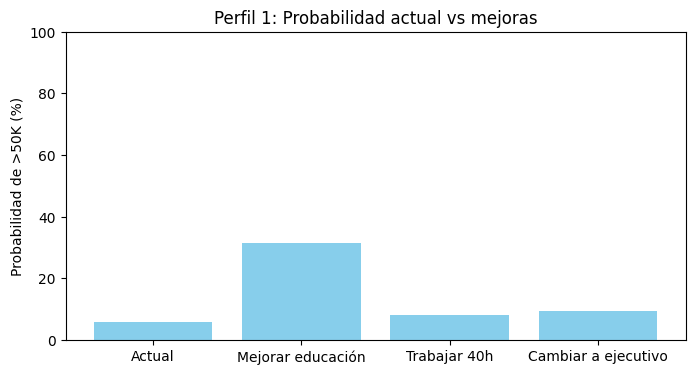


--- Perfil 2 ---
Probabilidad actual: 71.18%
- Probabilidad media: podrías mejorar en algunos aspectos

Recomendaciones (impacto en probabilidad):
- Aumentar educación a nivel universitario: probabilidad = 88.59%
- Cambiar de Tech-support a ocupación ejecutiva: probabilidad = 74.99%
- Trabajar hasta 40 horas semanales: probabilidad = 72.61%


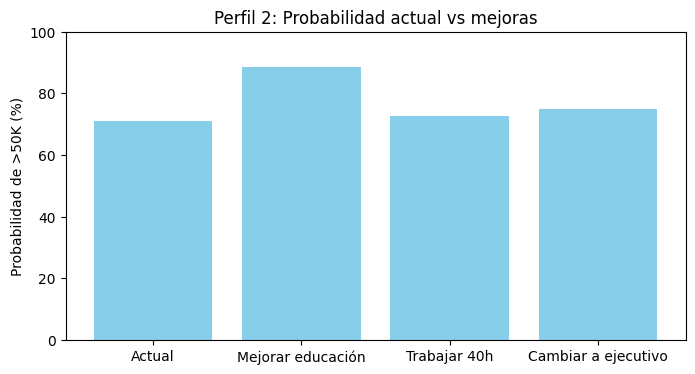


--- Perfil 3 ---
Probabilidad actual: 9.73%
✖ Baja probabilidad: necesitas mejoras para superar los 50K

Recomendaciones (impacto en probabilidad):
- Cambiar de Adm-clerical a ocupación ejecutiva: probabilidad = 18.28%
- Aumentar educación a nivel universitario: probabilidad = 16.05%
- Trabajar hasta 40 horas semanales: probabilidad = 11.40%


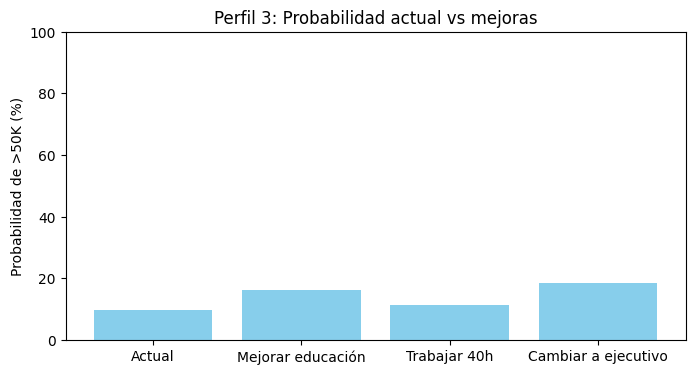

In [17]:
for i, perfil in enumerate(perfiles, 1):
    print(f"\n--- Perfil {i} ---")

    resultados = recomendar_mejoras(perfil)
    
    # Graficar
    plt.figure(figsize=(8,4))
    plt.bar(resultados.keys(), [p*100 for p in resultados.values()], color='skyblue')
    plt.ylabel("Probabilidad de >50K (%)")
    plt.title(f"Perfil {i}: Probabilidad actual vs mejoras")
    plt.ylim(0, 100)
    plt.show()

## 6. Guardar Modelo

In [ ]:
with open("modelo_recomendacion.sav", "wb") as f:
    pickle.dump(model, f)

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        num_features, cat_features
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression())
])

In [30]:
print(model.named_steps["preprocessor"].transformers)



[['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'], ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']]


In [48]:
de = adult.data.features.copy()
de[["education", "education-num"]].drop_duplicates().sort_values("education-num")

,education,education-num
224,Preschool,1
160,1st-4th,2
56,5th-6th,3
15,7th-8th,4
6,9th,5
77,10th,6
3,11th,7
415,12th,8
2,HS-grad,9
10,Some-college,10


In [50]:
de_mapping = de[["education", "education-num"]].drop_duplicates().sort_values("education-num")
de_mapping.to_csv("education_mapping.csv", index=False)